# RNN prediction for future value
It can predict no. of days in advance. You can configure 'future' parameter to adjust no. of days to predict by looking at no. of day to 'lookback'.

Adapted from https://github.com/ivanarielcaceres/timeseries-lstm-keras/blob/master/.ipynb_checkpoints/timeseries-prediction-checkpoint.ipynb

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import numpy as np
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
df = pd.read_csv('J69U.SI.csv')
print(df.head())

         Date  Open  High   Low  Close  Adj Close    Volume
0  2007-11-07  1.47  1.47  1.47   1.47   0.770844    6000.0
1  2007-11-09  1.45  1.46  1.45   1.46   0.765600   24000.0
2  2007-11-12  1.45  1.45  1.38   1.40   0.734137  133000.0
3  2007-11-13  1.40  1.40  1.38   1.38   0.723649   58000.0
4  2007-11-14  1.39  1.42  1.39   1.41   0.739380   60000.0


# Data cleansing

In [3]:
df = df[['Date','Open']]
df.set_index('Date', inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 2873


,Open
Date,
2007-11-07,1.47
2007-11-09,1.45
2007-11-12,1.45
2007-11-13,1.40
2007-11-14,1.39


In [4]:
df.describe()

,Open
count,2872.000000
mean,1.713101
std,0.435331
min,0.500000
25%,1.430000
50%,1.850000
75%,2.060000
max,2.410000


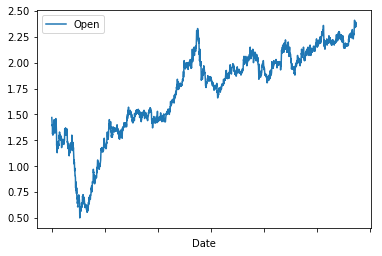

In [5]:
df.plot()

Null values?

In [6]:
df.isnull().sum()

Open    1
dtype: int64

In [7]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Open    1
dtype: int64

In [8]:
print(df[df.isnull().any(axis=1)][null_columns].head())

            Open
Date            
2008-10-27   NaN


In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

Open    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A642FC5940>]],
      dtype=object)

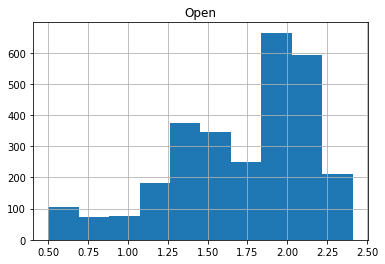

In [11]:
df.hist(bins=10)

In [12]:
len(df[df['Open'] == 0])

0

# Scaled data

In [13]:
print('Min', np.min(df))
print('Max', np.max(df))

Min Open    0.5
dtype: float64
Max Open    2.41
dtype: float64


We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [14]:
dataset = df.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

C:\Users\kohte\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [17]:
print(scaled[:10])

[[0.5078534 ]
 [0.4973822 ]
 [0.4973822 ]
 [0.47120415]
 [0.46596856]
 [0.47120415]
 [0.42931938]
 [0.42408372]
 [0.42931938]
 [0.44502617]]


# Create the RNN

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.
Split into train and test sets

In [18]:
train_size = int(len(scaled) * 0.65)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 1866
test: 1006


convert an array of values into a dataset matrix

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the energy quantity at a given time (t) and Y is the qty of energy at the next time (t + 1 + future).

In [19]:
future = 1

def create_dataset(dataset, look_back=20):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-future):
        a = dataset[i:(i+look_back), 0]
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+future, 0])
    return np.array(dataX), np.array(dataY)

reshape into X=t and Y=t+1

In [20]:
look_back = 30
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1866 30
1006 30


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].


reshape input to be [samples, time steps, features]

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
len_train = X_train.shape[0]
len_test = X_test.shape[0]
print(X_train.shape)
print(X_test.shape)

(1834, 30, 1)
(974, 30, 1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


create and fit the LSTM network

In [22]:
def computeHCF(x, y):

# choose the smaller number
    if x > y:
        smaller = y
    else:
        smaller = x
    for i in range(1, smaller+1):
        if((x % i == 0) and (y % i == 0)):
            hcf = i
            
    return hcf
batch_size = computeHCF(len_train,len_test)

print('batch_size : {}'.format(batch_size))
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, batch_input_shape=(batch_size, look_back, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True))

# Adding the output layer
model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())


batch_size : 2
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (2, 30, 50)               10400     
_________________________________________________________________
dropout_1 (Dropout)          (2, 30, 50)               0         
_________________________________________________________________
lstm_2 (LSTM)                (2, 30, 50)               20200     
_________________________________________________________________
dropout_2 (Dropout)          (2, 30, 50)               0         
_________________________________________________________________
lstm_3 (LSTM)                (2, 30, 50)               20200     
_________________________________________________________________
dropou

# Generate the model

In [23]:
model.fit(X_train, y_train, epochs=300, batch_size=batch_size, verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
 - 147s - loss: 0.0077
Epoch 2/300
 - 177s - loss: 0.0041
Epoch 3/300
 - 187s - loss: 0.0029
Epoch 4/300
 - 187s - loss: 0.0023
Epoch 5/300
 - 187s - loss: 0.0025
Epoch 6/300
 - 187s - loss: 0.0020
Epoch 7/300
 - 188s - loss: 0.0019
Epoch 8/300
 - 188s - loss: 0.0016
Epoch 9/300
 - 188s - loss: 0.0015
Epoch 10/300
 - 188s - loss: 0.0015
Epoch 11/300
 - 188s - loss: 0.0014
Epoch 12/300
 - 189s - loss: 0.0015
Epoch 13/300
 - 188s - loss: 0.0013
Epoch 14/300
 - 188s - loss: 0.0013
Epoch 15/300
 - 188s - loss: 0.0013
Epoch 16/300
 - 189s - loss: 0.0013
Epoch 17/300
 - 188s - loss: 0.0013
Epoch 18/300
 - 189s - loss: 0.0012
Epoch 19/300
 - 189s - loss: 0.0012
Epoch 20/300
 - 189s - loss: 0.0011
Epoch 21/300
 - 188s - loss: 0.0012
Epoch 22/300
 - 188s - loss: 0.0011
Epoch 23/300
 - 189s - loss: 0.0011
Epoch 24/300
 - 188s - loss: 0.0010
Epoch 25/300
 - 189s - loss: 0.0011
Epoch 26/300
 - 188s - loss: 0.0010
Epoch 27/300
 - 188s - lo

 - 188s - loss: 0.0014
Epoch 202/300
 - 189s - loss: 0.0015
Epoch 203/300
 - 188s - loss: 0.0014
Epoch 204/300
 - 189s - loss: 0.0014
Epoch 205/300
 - 188s - loss: 0.0012
Epoch 206/300
 - 189s - loss: 0.0013
Epoch 207/300
 - 189s - loss: 0.0012
Epoch 208/300
 - 188s - loss: 0.0012
Epoch 209/300
 - 189s - loss: 0.0011
Epoch 210/300
 - 189s - loss: 0.0011
Epoch 211/300
 - 189s - loss: 0.0011
Epoch 212/300
 - 189s - loss: 0.0012
Epoch 213/300
 - 188s - loss: 0.0011
Epoch 214/300
 - 189s - loss: 9.9598e-04
Epoch 215/300
 - 188s - loss: 0.0010
Epoch 216/300
 - 189s - loss: 0.0011
Epoch 217/300
 - 189s - loss: 0.0011
Epoch 218/300
 - 189s - loss: 0.0011
Epoch 219/300
 - 189s - loss: 9.7521e-04
Epoch 220/300
 - 189s - loss: 9.3257e-04
Epoch 221/300
 - 189s - loss: 9.4153e-04
Epoch 222/300
 - 192s - loss: 9.3034e-04
Epoch 223/300


KeyboardInterrupt: 

Make preditions

In [24]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
model.reset_states()
# invert predictions
trainPredict_inv_scl = scaler.inverse_transform(trainPredict)
y_train_inv_scl = scaler.inverse_transform([y_train])
testPredict_inv_scl = scaler.inverse_transform(testPredict)
y_test_inv_scl = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv_scl[0], trainPredict_inv_scl[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv_scl[0], testPredict_inv_scl[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.05 RMSE


Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


shift train predictions for plotting

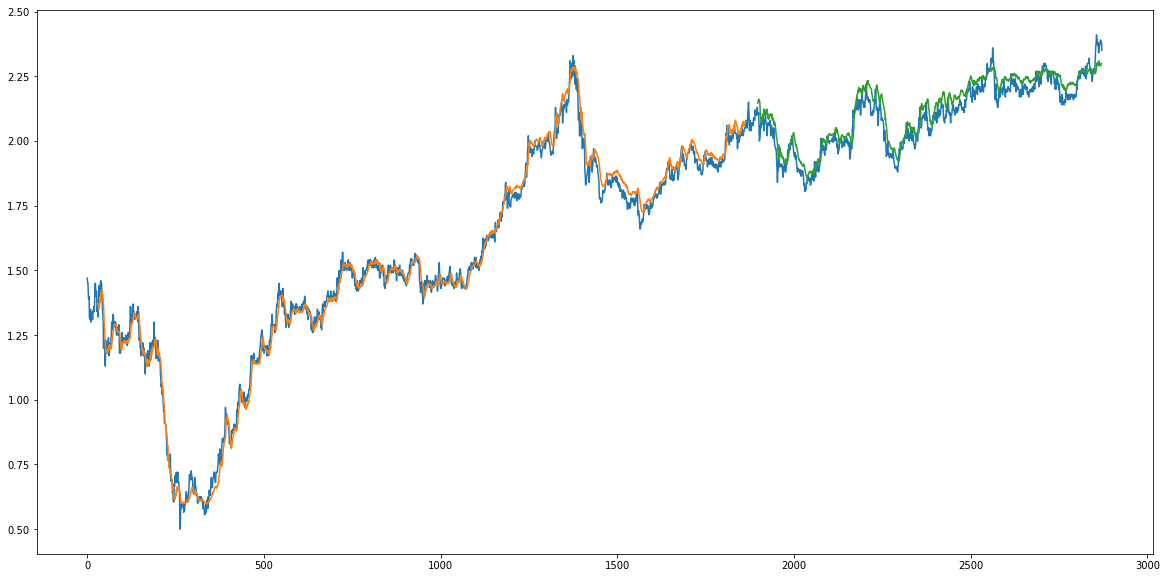

In [26]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_inv_scl
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+((look_back+future)*2)+1:len(scaled)-1, :] = testPredict_inv_scl
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.xlim(1000,1100)
plt.show()

# Save the model

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Load the model

In [28]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


# Test Loaded Model

In [ ]:
trainPredict = loaded_model.predict(X_train, batch_size=batch_size)
loaded_model.reset_states()

testPredict = loaded_model.predict(X_test, batch_size=batch_size)
loaded_model.reset_states()
# invert predictions
trainPredict_inv_scl = scaler.inverse_transform(trainPredict)
y_train_inv_scl = scaler.inverse_transform([y_train])
testPredict_inv_scl = scaler.inverse_transform(testPredict)
y_test_inv_scl = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv_scl[0], trainPredict_inv_scl[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv_scl[0], testPredict_inv_scl[:,0]))
print('Test Score: %.2f RMSE' % (testScore))